# 4.2b - Compare all pairs of classes. How easy is to distinguish between them?

In [1]:
import os
import sys
import datetime
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset
from block_sampler import count_sectors, BlockSamplerByCategory, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2b-pairs'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [4]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

# Create models

In [5]:
cats = rawset.categories
tsets, vsets = rawset.rnd_split_fraction_by_category(0.5)
tsets = tsets.by_category()
vsets = vsets.by_category()
r = report.Reporter2(result_dir + '/creation.tsv')
for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        print(cats[i], cats[j])
        mycats = [cats[i], cats[j]]
        myset = rawset.filter(lambda x: rawset.category_from(x) in mycats)
        myset.rebuild_categories()
        tset, vset = myset.rnd_split_fraction_by_category(0.5)

        model = CM(2, 256)
        result = Trainer(
            model,
            xs_encoder='one_hot',
            batch_size=100,
            steps_per_epoch=2,
            validation_steps=2*2,
            patience=10,
        ).train(tset, vset)
        h5_path = os.path.join(result_dir, '%s_%s.h5' % (cats[i], cats[j]))
        model.save(h5_path)
        print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])
        r.line(cat1=cats[i],
               cat2=cats[j],
               elapsed=result.elapsed,
               **report.report_epochs(**result._asdict()),
               **report.report_metrics(**result._asdict()),
              )
r.close()

csv dbase3
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
252.63246870040894 0.98
csv doc
52.8124840259552 0.85
csv dwf
66.22233939170837 1.0
csv eps
121.96383357048035 0.98
csv f
173.2231764793396 0.9225
csv gif
59.136841773986816 1.0
csv gz
74.64308977127075 1.0
csv hlp
177.2955253124237 0.9775
csv html
131.40767240524292 0.9725
csv java
83.82901072502136 0.9675
csv jpg
83.06500244140625 1.0
csv kml
106.75488686561584 0.97
csv kmz
65.24226903915405 0.995
csv log
130.16287326812744 0.95
csv pdf
157.51558828353882 0.9775
csv png
80.08983588218689 1.0
csv pps
81.39020848274231 0.9825
csv ppt
106.46516036987305 0.965
csv pptx
106.34850263595581 0.9925
csv ps
125.80348443984985 0.965
csv rtf
147.58850359916687 0.9725
csv sql
106.5432288646698 0.9375
csv swf
67.85900235176086 0.9975
csv txt
164.78634023666382 0.9275
csv wp
63.605409145355225 0.9225
csv xls
49.408798694610596 0.94
csv xml
114.06255102157593 0.9725
dbase3

209.40623545646667 0.9
jpg kml
96.67551445960999 0.99
jpg kmz
211.7105097770691 0.755
jpg log
104.29112482070923 0.9925
jpg pdf
136.34092473983765 0.705
jpg png
86.9580352306366 0.5325
jpg pps
125.44760370254517 0.5875
jpg ppt
184.7761311531067 0.645
jpg pptx
120.87629103660583 0.595
jpg ps
126.39188051223755 0.98
jpg rtf
102.89771294593811 0.9925
jpg sql
116.00408911705017 0.9975
jpg swf
107.56394696235657 0.5825
jpg txt
106.3268723487854 0.99
jpg wp
183.6434497833252 0.975
jpg xls
166.68998908996582 0.9575
jpg xml
96.03786277770996 0.99
kml kmz
109.51652264595032 1.0
kml log
148.4713044166565 0.9375
kml pdf
147.57305026054382 0.925
kml png
120.89200234413147 1.0
kml pps
149.71135258674622 0.975
kml ppt
179.31993055343628 0.9775
kml pptx
143.85510659217834 0.995
kml ps
144.6248972415924 0.9525
kml rtf
171.38672876358032 0.99
kml sql
167.86375546455383 0.975
kml swf
104.5402238368988 0.985
kml txt
124.07784843444824 0.9475
kml wp
213.5848524570465 0.975
kml xls
102.51017880439758 0.945

# Load results

In [6]:
data = pd.read_csv(result_dir + '/creation.tsv', sep='\t')
data

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
0,csv,dbase3,252.632469,68,0.9800,0.9800
1,csv,doc,52.812484,14,0.8500,0.8500
2,csv,dwf,66.222339,18,1.0000,1.0000
3,csv,eps,121.963834,31,0.9800,0.9800
4,csv,f,173.223176,46,0.9225,0.9225
...,...,...,...,...,...,...
373,txt,xls,124.492454,17,0.9000,0.9000
374,txt,xml,183.598497,32,0.8350,0.8350
375,wp,xls,204.245162,38,0.8675,0.8675
376,wp,xml,226.492357,43,0.8750,0.8750


In [7]:
data = data.sort_values(['val_categorical_accuracy'])
data[data['val_categorical_accuracy'] < 0.7]

,cat1,cat2,elapsed,Epochs,val_binary_accuracy,val_categorical_accuracy
81,dwf,gz,123.902378,26,0.5175,0.5175
323,pps,ppt,131.100164,21,0.5250,0.5250
90,dwf,png,73.659772,15,0.5275,0.5275
246,jpg,png,86.958035,13,0.5325,0.5325
328,pps,swf,156.622626,28,0.5400,0.5400
176,gz,png,71.295077,12,0.5525,0.5525
85,dwf,jpg,60.227082,11,0.5600,0.5600
91,dwf,pps,102.805545,22,0.5650,0.5650
337,ppt,swf,178.687951,36,0.5650,0.5650
93,dwf,pptx,131.130602,25,0.5825,0.5825


In [8]:
data2 = data.apply(
    lambda x: pd.Series(
        [
            rawset.cat_to_ix[x.cat1],
            rawset.cat_to_ix[x.cat2], 
            x.val_categorical_accuracy
        ], index=['cat1', 'cat2', 'val_acc'])
    , axis=1)
data2

,cat1,cat2,val_acc
81,3.0,7.0,0.5175
323,17.0,18.0,0.5250
90,3.0,16.0,0.5275
246,11.0,16.0,0.5325
328,17.0,23.0,0.5400
...,...,...,...
258,12.0,13.0,1.0000
174,7.0,14.0,1.0000
83,3.0,9.0,1.0000
273,13.0,14.0,1.0000


In [9]:
cat_acc = {}
for i, d in data.iterrows():
    cat1 = d['cat1']
    cat2 = d['cat2']
    cat_acc[cat1] = cat_acc.get(cat1, list())
    cat_acc[cat2] = cat_acc.get(cat2, list())
    cat_acc[cat1].append(d['val_categorical_accuracy'])
    cat_acc[cat2].append(d['val_categorical_accuracy'])    

No handles with labels found to put in legend.


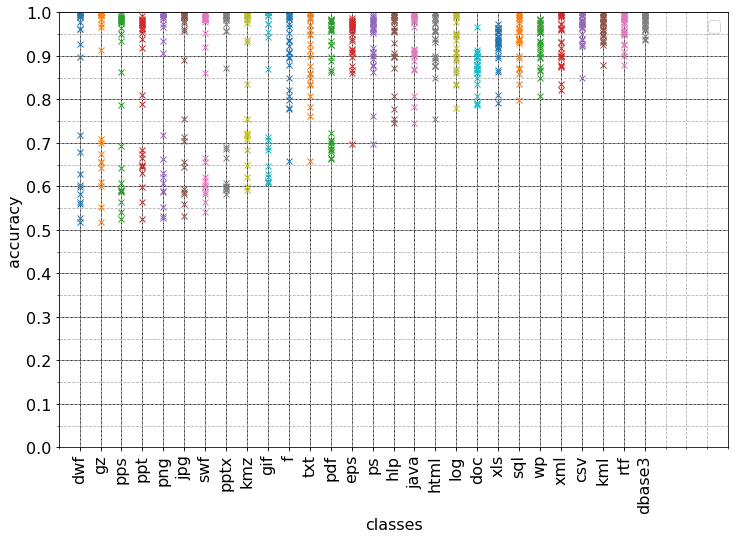

In [10]:
from matplotlib.ticker import MultipleLocator
loc='upper right'
fig = plt.figure(figsize=(12,8))
for k, v in cat_acc.items():
    plt.plot(*zip(*[(k, x) for x in v]), 'x')
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('classes', fontsize=16)
plt.xlim((-1, 31))
plt.ylim((-0, 1))
ax1 = plt.gca()
# ax1.xaxis.set_major_locator(MultipleLocator(5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_major_locator(MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(linestyle='-', color='k', which='major')
plt.grid(linestyle='--', which='minor')
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.legend(loc=loc, prop={'size': 16})
plt.xticks(rotation=90)
#     plt.savefig('acc.png')
plt.show()    

In [11]:
data.min()

cat1                            csv
cat2                         dbase3
elapsed                     49.4088
Epochs                           11
val_binary_accuracy          0.5175
val_categorical_accuracy     0.5175
dtype: object

In [12]:
with open(result_dir + '/nclasses.tsv', 'w') as f:
    f.write('n\tcats\tval_categorical_accuracy\n')
    for i, x in data.iterrows():
        s = '2\t{}\t{}\n'.format(x.cat1+','+x.cat2,x.val_categorical_accuracy)
        f.write(s)

# Add pairs of classes to graph 4.2a

In [13]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

In [14]:
data42a = pd.read_csv('results/4.2a-nclasses/nclasses.tsv', sep='\t')
data42b = pd.read_csv('results/4.2b-pairs/nclasses.tsv', sep='\t')
mdata = pd.concat([data42a, data42b])

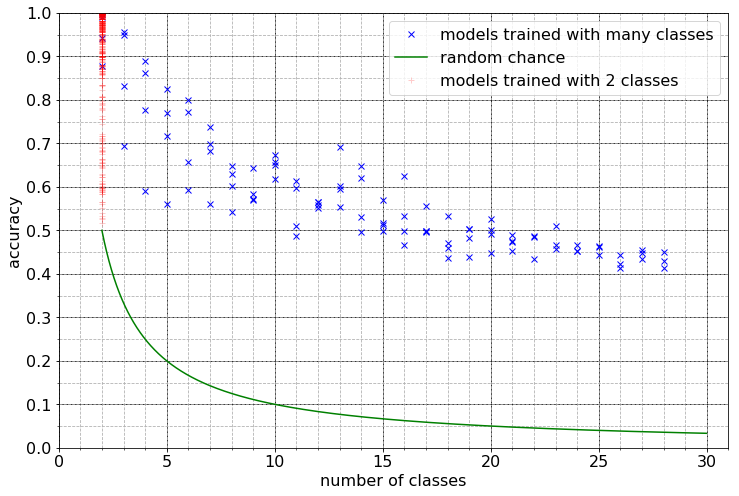

In [15]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([data42a['n'], x], [data42a['val_categorical_accuracy'], y], ['models trained with many classes', 'random chance'])
plt.plot(data42b['n'], data42b['val_categorical_accuracy'], 'r+', alpha=0.2, label='models trained with 2 classes')
plt.legend(loc='upper right', prop={'size': 16})

# PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA(n_components=2)

In [18]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.5000,0.9800,0.8500,1.0000,0.9800,0.9225,1.0000,1.0000,0.9775,0.9725,...,0.9650,0.9925,0.9650,0.9725,0.9375,0.9975,0.9275,0.9225,0.9400,0.9725
1,0.9800,0.5000,0.9675,1.0000,0.9675,0.9375,1.0000,1.0000,0.9825,0.9600,...,0.9925,0.9950,0.9900,0.9875,0.9400,1.0000,0.9700,0.9825,0.9625,0.9725
2,0.8500,0.9675,0.5000,0.8975,0.8975,0.8975,0.8700,0.9125,0.8975,0.8775,...,0.7900,0.8725,0.9100,0.8800,0.9000,0.8600,0.8600,0.8075,0.7925,0.8800
3,1.0000,1.0000,0.8975,0.5000,0.9775,0.9925,0.6275,0.5175,0.9975,1.0000,...,0.5975,0.5825,0.9625,0.9925,0.9900,0.6025,0.9975,0.9625,0.9275,1.0000
4,0.9800,0.9675,0.8975,0.9775,0.5000,0.9075,0.9725,0.9675,0.9575,0.9400,...,0.9700,0.9725,0.6975,0.9100,0.9350,0.9875,0.9125,0.9700,0.9650,0.8775
5,0.9225,0.9375,0.8975,0.9925,0.9075,0.5000,1.0000,0.9950,0.7775,0.8500,...,0.9725,0.9925,0.8800,0.9525,0.7975,0.9950,0.6575,0.9100,0.8950,0.8225
6,1.0000,1.0000,0.8700,0.6275,0.9725,1.0000,0.5000,0.6100,1.0000,1.0000,...,0.6475,0.6900,0.9725,0.9925,1.0000,0.6125,1.0000,0.9550,0.9425,1.0000
7,1.0000,1.0000,0.9125,0.5175,0.9675,0.9950,0.6100,0.5000,1.0000,1.0000,...,0.6750,0.6000,0.9950,0.9950,0.9975,0.6550,1.0000,0.9850,0.9725,1.0000
8,0.9775,0.9825,0.8975,0.9975,0.9575,0.7775,1.0000,1.0000,0.5000,0.7550,...,0.9825,0.9950,0.9675,0.9550,0.8725,0.9900,0.8075,0.8975,0.9300,0.9000
9,0.9725,0.9600,0.8775,1.0000,0.9400,0.8500,1.0000,1.0000,0.7550,0.5000,...,0.9750,0.9900,0.8775,0.9575,0.9400,0.9875,0.8775,0.8950,0.9550,0.9000


In [19]:
data6 = pca.fit_transform(data5)

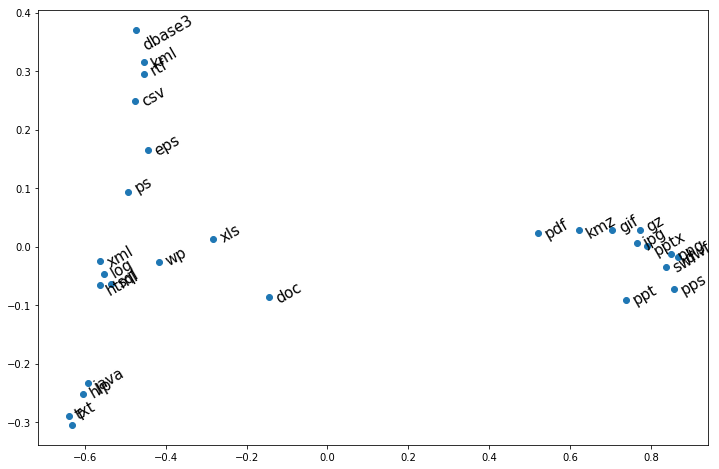

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data6[:,0], data6[:,1], 'o')

for i in range(28):
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.01, data6[i,1]+0.01),fontsize=15)
    t.set_rotation(30)

In [21]:
data6[:,0]>0.4

array([False, False, False,  True, False, False,  True,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True, False, False, False,  True, False, False, False,
       False])

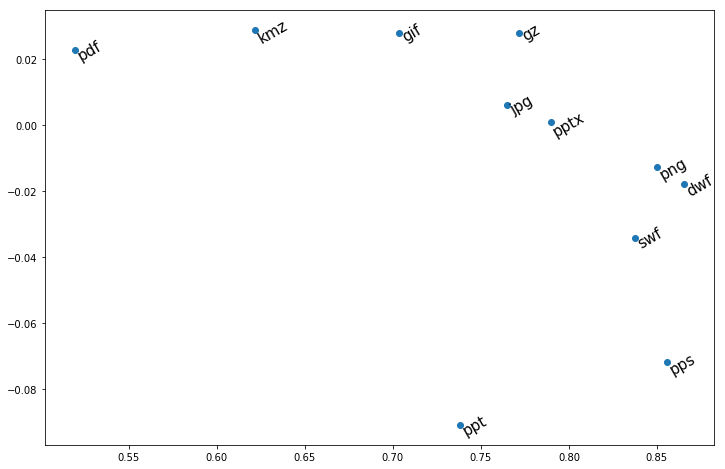

In [22]:
data7 = data6[data6[:,0]>0.4]
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(len(data6)):
    if data6[i,0] < 0.4:
        continue
    t = ax.annotate(rawset.ix_to_cat[i], (data6[i,0]+0.0, data6[i,1]+0.0),fontsize=15)
    t.set_rotation(30)

# Multi-dimensional scaling

In [23]:
data5 = np.ones((28,28))*0.5

for idx, row in data2.iterrows():
    i = int(row.cat1)
    j = int(row.cat2)
    data5[i,j] = row.val_acc
    data5[j,i] = row.val_acc

data5 = pd.DataFrame(data5)
data5

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.5000,0.9800,0.8500,1.0000,0.9800,0.9225,1.0000,1.0000,0.9775,0.9725,...,0.9650,0.9925,0.9650,0.9725,0.9375,0.9975,0.9275,0.9225,0.9400,0.9725
1,0.9800,0.5000,0.9675,1.0000,0.9675,0.9375,1.0000,1.0000,0.9825,0.9600,...,0.9925,0.9950,0.9900,0.9875,0.9400,1.0000,0.9700,0.9825,0.9625,0.9725
2,0.8500,0.9675,0.5000,0.8975,0.8975,0.8975,0.8700,0.9125,0.8975,0.8775,...,0.7900,0.8725,0.9100,0.8800,0.9000,0.8600,0.8600,0.8075,0.7925,0.8800
3,1.0000,1.0000,0.8975,0.5000,0.9775,0.9925,0.6275,0.5175,0.9975,1.0000,...,0.5975,0.5825,0.9625,0.9925,0.9900,0.6025,0.9975,0.9625,0.9275,1.0000
4,0.9800,0.9675,0.8975,0.9775,0.5000,0.9075,0.9725,0.9675,0.9575,0.9400,...,0.9700,0.9725,0.6975,0.9100,0.9350,0.9875,0.9125,0.9700,0.9650,0.8775
5,0.9225,0.9375,0.8975,0.9925,0.9075,0.5000,1.0000,0.9950,0.7775,0.8500,...,0.9725,0.9925,0.8800,0.9525,0.7975,0.9950,0.6575,0.9100,0.8950,0.8225
6,1.0000,1.0000,0.8700,0.6275,0.9725,1.0000,0.5000,0.6100,1.0000,1.0000,...,0.6475,0.6900,0.9725,0.9925,1.0000,0.6125,1.0000,0.9550,0.9425,1.0000
7,1.0000,1.0000,0.9125,0.5175,0.9675,0.9950,0.6100,0.5000,1.0000,1.0000,...,0.6750,0.6000,0.9950,0.9950,0.9975,0.6550,1.0000,0.9850,0.9725,1.0000
8,0.9775,0.9825,0.8975,0.9975,0.9575,0.7775,1.0000,1.0000,0.5000,0.7550,...,0.9825,0.9950,0.9675,0.9550,0.8725,0.9900,0.8075,0.8975,0.9300,0.9000
9,0.9725,0.9600,0.8775,1.0000,0.9400,0.8500,1.0000,1.0000,0.7550,0.5000,...,0.9750,0.9900,0.8775,0.9575,0.9400,0.9875,0.8775,0.8950,0.9550,0.9000


In [24]:
from sklearn.manifold import MDS

In [25]:
mds = MDS(n_components=2,max_iter=3000, eps=1e-9,
          n_jobs=1)

In [26]:
data7 = mds.fit_transform(data5)

/home/atila.alr/.local/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


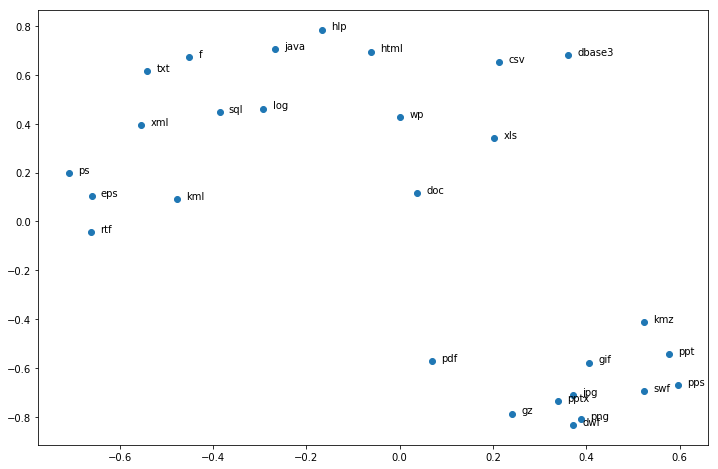

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(data7[:,0], data7[:,1], 'o')
for i in range(28):
    ax.annotate(rawset.ix_to_cat[i], (data7[i,0]+0.02, data7[i,1]))